In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader

from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torchvision.datasets.utils import download_url
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import tarfile
import os

## Exploring MNIST dataset

### Downloading/Loading CIFAR10 

In [2]:
# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

In [3]:
# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [2]:
# Viewing the data
data_dir = './data/cifar10'
print("Directories: ", os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print("Classes: ", classes)

Directories:  ['train', 'test']
Classes:  ['frog', 'horse', 'airplane', 'dog', 'deer', 'automobile', 'cat', 'truck', 'ship', 'bird']


Checking some of the contents of the folders

In [5]:
airplane_files = os.listdir(data_dir + "/train/airplane")
print('No. of training examples for airplanes:', len(airplane_files))
print(airplane_files[:5])

No. of training examples for airplanes: 5000
['3776.png', '0676.png', '0690.png', '3704.png', '0494.png']


The above directory structure of one folder per class is used by many computer vision datasets, so the `torchvision.ImageFolder` class from  is used to load such a dataset as PyTorch tensors.

In [3]:
dataset = ImageFolder(data_dir+'/train', transform=transforms.ToTensor())
dataset

Dataset ImageFolder
    Number of datapoints: 50000
    Root location: ./data/cifar10/train
    StandardTransform
Transform: ToTensor()

Plotting first 10 images in the dataset along with their target labels.

```torch.permute()``` rearranges the original tensor according to the desired ordering and returns a new multidimensional rotated tensor. We use this to change the dimensions from (3, 32, 32) to (32, 32, 3).

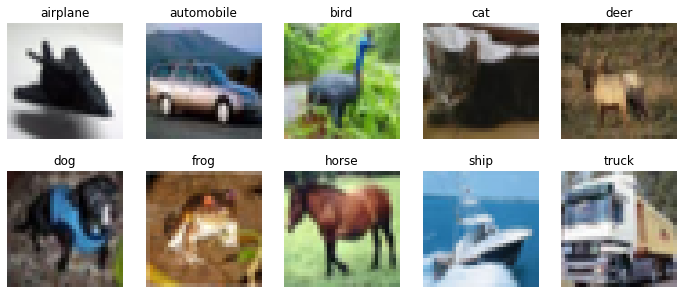

In [8]:
fig, axes = plt.subplots(2, 5, figsize=(12,5))

for i in range(10):
    axes[i//5, i%5].imshow(dataset[i*5000][0].permute(1, 2, 0))
    axes[i//5, i%5].set_title(dataset.classes[dataset[i*5000][1]])
    axes[i//5, i%5].axis("off")

### Selecting part of dataset

In [4]:
split = (100/100)

selected_size = int(len(dataset) * split)
removed_size = len(dataset) - selected_size
dataset, _ = random_split(dataset, [selected_size, removed_size])

print(len(dataset))

50000


### Splitting dataset to training and validation

In [5]:
val_split = (1/10)

val_size = int(len(dataset) * val_split)
train_size = len(dataset) - val_size

In [6]:
train_set, val_set = random_split(dataset, [train_size, val_size])

print(len(train_set), len(val_set))

45000 5000


### Creating dataloader

In [7]:
batch_size = 32

train_dl = DataLoader(train_set, batch_size, shuffle=True)
val_dl = DataLoader(val_set, batch_size)

We can look at batches of images from the dataset using the `torchvision.utils.make_grid` method.

Each time the following code is run, we get a different bach, since the sampler shuffles the indices before creating batches.

In [8]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

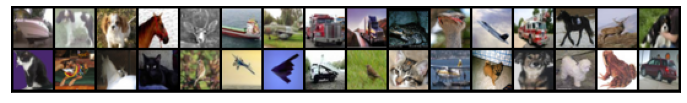

In [9]:
show_batch(train_dl)

## CNN Model

### Defining model a sample CNN model

In [10]:
simple_model = nn.Sequential(
    # Input channel = 3, output channel =32 
    nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2, 2)
)

In [11]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    with torch.no_grad():
        out = simple_model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([32, 3, 32, 32])
out.shape: torch.Size([32, 8, 16, 16])


Visualizing the 8 channels of output for one image after passing through the convolution.

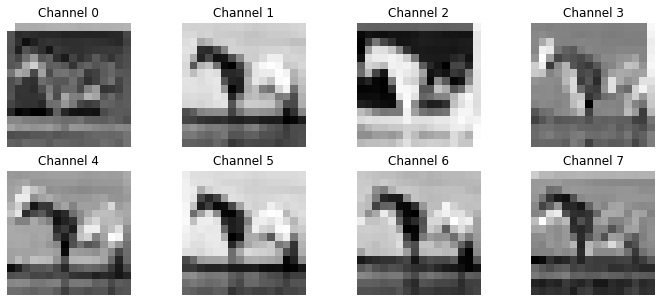

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(12,5))

for i in range(8):
    axes[i//4, i%4].imshow(out[3][i,:,:], cmap = 'gray')
    axes[i//4, i%4].set_title("Channel {}".format(i))
    axes[i//4, i%4].axis("off")

### Defining main CNN model

In [13]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Create Sequential network
        self.network = nn.Sequential(
            # Convolution layers
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            # Activation function
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # Max-pooling layer
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
            
    ## Returns the value after forward pass
    def forward(self, x):
        return self.network(x)
    
    ## Returns loss for a training batch
    def training_step(self, batch):
        images, labels = batch 
        # Generate predictions
        out = self(images)            
        # Calculate loss
        loss = F.cross_entropy(out, labels) 
        return loss
    
    ## Returns the loss and accuracy for a validation batch
    def validation_step(self, val_batch):
        images, labels = val_batch 
        
        # Generate predictions
        out = self(images)            
        
        # Calculate loss
        val_loss = F.cross_entropy(out, labels) 
        val_acc = accuracy(out, labels)
        
        return {"val_loss":val_loss, "val_acc":val_acc}
    
    ## Returns mean loss and mean accuracy from the losses and accuracies of all the batches
    def validation_epoch_end(self, outputs):
        
        # Losses for each batch
        batch_losses = [x['val_loss'] for x in outputs]
        
        # Mean loss for all batch
        batch_mean_loss = torch.tensor(batch_losses).mean()
        
        # Accuracies for each batches
        batch_accs = [x['val_acc'] for x in outputs]
        
        # Mean accuracy for all batches
        batch_mean_acc = torch.tensor(batch_accs).mean()
        
        return {"val_loss":batch_mean_loss, "val_acc":batch_mean_acc}
    
    ## Prints validation loss and accuracy for epoch (mean of all batches)
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [14]:
# Accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

### Using a GPU

First we check whether CUDA is available or not.

In [15]:
torch.cuda.is_available()

True

Function to get GPU device if available, else CPU.

In [16]:
def get_default_device():
  if(torch.cuda.is_available()):
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [17]:
device = get_default_device()
device

device(type='cuda')

Function fo move data and model to the available device.

In [18]:
def to_device(data, device):
  # If data is list or tuple, perform to_device for each element
  if(isinstance(data, (list, tuple))):
    return([to_device(x, device) for x in data])
    
  return data.to(device, non_blocking = True)

In [14]:
# Example of moving data to device
to_device(torch.Tensor([1,2,3]), device)

tensor([1., 2., 3.], device='cuda:0')

In [112]:
for images, labels in train_dl:
  images = to_device(images, device)
  print(images.device)
  break

cuda:0


We define a `DeviceDataLoader` class to wrap our existing data loaders and move batches of data to the selected device. 

We don't need to extend an existing class to create a PyTorch dataloader. All we need is an `__iter__` method to retrieve batches of data and an `__len__` method to get the number of batches.

In [19]:
class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for batch in self.dl:
      yield to_device(batch, self.device)

  def __len__(self):
    return(len(self.dl))

We can now wrap our data loaders using `DeviceDataLoader`.

In [20]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

Let us check the device of these dataloaders.

In [21]:
for im, lb in train_dl:
  print(im.device)
  break

for im, lb in val_dl:
  print(im.device)
  break

cuda:0
cuda:0


### Training function

In [22]:
# Utility function to train the model

def fit(epochs, model, learning_rate, train_loader, val_loader):
    print("Training")
    
    # For recording epoch wise results
    history = []
    opt = torch.optim.Adam(model.parameters(), learning_rate)
    
    for i in range(epochs):
        train_losses = []
        model.train()
        for batch in train_loader:
            # Make prediction & Calculate loss
            loss = model.training_step(batch)
            
            # Calculating loss, accuracy
            train_losses.append(loss)
            
            # Compute gradients
            loss.backward()
            
            # Update parameters using gradients
            opt.step()
            
            # Reset gradients to zero
            opt.zero_grad()
            
            
            
        ## Validation phase 
        model.eval()
        train_loss = torch.stack(train_losses).mean().item() #torch.tensor(train_losses).mean()
        
        result = evaluate(model, val_loader)
        result['train_loss'] = train_loss
        model.epoch_end(i, result)
        history.append(result)
            
    return history


In [23]:
def evaluate(model, val_loader):
    
    # List containing evaluations for every batch
    outputs = [model.validation_step(batch) for batch in val_loader]
    
    return model.validation_epoch_end(outputs)

### Creating and training model

In [32]:
# Hyperparameters
learning_rate = 0.001

# Create model
model = Model()
model

# Moving model to device
to_device(model, device)

Model(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=1024,

In [33]:
history = fit(10, model, learning_rate, train_dl, val_dl)

Training
Epoch [0], train_loss: 1.8052, val_loss: 1.4616, val_acc: 0.4473
Epoch [1], train_loss: 1.2848, val_loss: 1.1455, val_acc: 0.5836
Epoch [2], train_loss: 1.0320, val_loss: 0.9738, val_acc: 0.6513
Epoch [3], train_loss: 0.8754, val_loss: 0.9212, val_acc: 0.6766
Epoch [4], train_loss: 0.7608, val_loss: 0.8457, val_acc: 0.7080
Epoch [5], train_loss: 0.6680, val_loss: 0.8560, val_acc: 0.7006
Epoch [6], train_loss: 0.5915, val_loss: 0.8164, val_acc: 0.7241
Epoch [7], train_loss: 0.5222, val_loss: 0.8505, val_acc: 0.7239
Epoch [8], train_loss: 0.4588, val_loss: 0.8744, val_acc: 0.7367
Epoch [9], train_loss: 0.4079, val_loss: 0.8963, val_acc: 0.7269


Now we plot the evaluation metrics for all epochs.

In [37]:
train_losses = [l['train_loss'] for l in history]
val_losses = [l['val_loss'] for l in history]
acc = [a['val_acc'] for a in history]

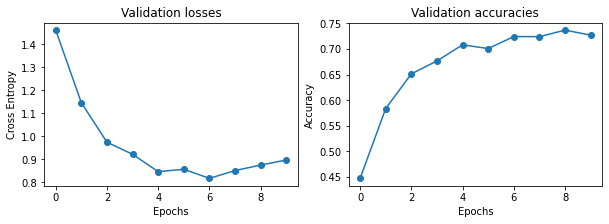

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(10,3))

axes[0].plot(val_losses, '-o')
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Cross Entropy")
axes[0].set_title("Validation losses")

axes[1].plot(acc, '-o')
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Validation accuracies")
plt.show()

Now we'll compare the training and validation loss.

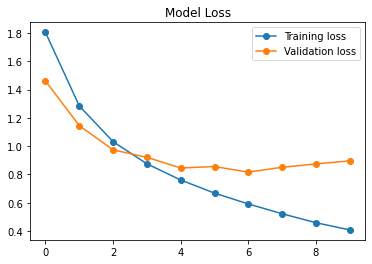

In [38]:
plt.plot(train_losses, '-o')
plt.plot(val_losses, '-o')
plt.legend(["Training loss", "Validation loss"])
plt.title("Model Loss")
plt.show()

The model is slightly overfitting after around 4th epoch.

### Saving model

In [48]:
torch.save(model.state_dict(), 'cifar10-cnn.pth')

### Checking model performance on test dataset

In [41]:
# Testing dataset

test_dataset = ImageFolder(data_dir+'/test', transform=transforms.ToTensor())
test_dataset

Dataset ImageFolder
    Number of datapoints: 10000
    Root location: ./data/cifar10/test
    StandardTransform
Transform: ToTensor()

In [42]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

In [43]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size), device)

In [47]:
result = evaluate(model, test_loader)
print("Test Loss = {:.4f}, Test accuracy = {:.4F}".format(result['val_loss'], result['val_acc']))

In [ ]:
for img, lab in test_loader:
  test_labels = lab
  test_output_probs = model(img)
  break

_, test_output = torch.max(test_output_probs, dim = 1)

Now we visualize the test images with their predicted labels.

In [49]:
print(test_output[:10])
print(test_labels[:10])